In [1]:
import time
start_time=time.time()

Abstract

Se presenta un ajuste polinomial (0-6 ord) a los datos observacionales para investigar movimientos a gran escala (detrended data) en direciones X y Y.

In [2]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import os

import itertools
from scipy.interpolate import interp1d
from scipy import interpolate

from SABReXX import sosf,acf,psk,ps,sosfnorm,sosfw,sosfw2,sosfs,sosfnorms,sfwh,pst
from CorrPoldef import CPV,CPH
from LRdefX import LR,ACLR
from Pltdef import pltdata

plt.rcParams["font.family"]="Times New Roman"
plt.rcParams["font.size"]="15"

Input Data

In [3]:
#Input
#Constant
c=299792.459#km/s
#Iraf
corrhelio=25.68#km/s
#Theory Lambda
lr=[6562.8,6548,6583,6717,6731]#AngstromsR
#lb=[4861.36,4958.9,5006.9]#AngstromsB


n=7

Astronomical Observations

In [4]:
inputf='595.Isis.WHT.Red.txt'

data0=pd.read_table(inputf)
data1=data0.rename(columns={"Center":"Center.0","ErrC":"ErrC.0","Width":"Width.0","ErrW":"ErrW.0","Peak":"Peak.0","ErrP":"ErrP.0",})


In [5]:
#LimitData
min0=75
max0=130
mr=(data1.X<max0)&(data1.X>min0)
data1=data1[mr]

Emission lines data

In [6]:
for i in range(1):
    Nx=i
    N=str(Nx)

    data2=data1[['X','Y','Center.'+N,'Peak.'+N,'Width.'+N]]

    RVo=c*(data2["Center."+N]-lr[Nx])/lr[Nx]
    RV=RVo+corrhelio

    data2=data2.assign(RV=RV.values)

    a=[data2.X,data2.Y,data2.RV,data2['Peak.'+N]]
    data3=pd.DataFrame(a).T
    data3.columns=['X','Y','RV','I']
    data3.to_csv('dataII'+str(int(lr[Nx]))+'.csv')

# Muestra (i) H alfa

In [7]:
datap='dataII6562.csv'
dt=pd.read_csv(datap)
dt=dt.rename(columns={'Unnamed: 0':'No'})
dt=dt.drop('No',axis=1)
os.remove(datap)
dt.describe()

,X,Y,RV,I
count,369.00000,369.000000,369.000000,369.000000
mean,101.91600,10.555556,-1017.841296,1190.327263
std,15.88847,7.003320,15594.515616,1745.710725
min,75.09600,0.000000,-299766.779000,0.000000
25%,88.50600,5.000000,-213.594837,269.400000
50%,101.91600,11.000000,-204.641445,533.400000
75%,115.32600,15.000000,-196.555984,1159.000000
max,128.73600,22.000000,-177.781268,9957.000000


In [8]:
wd=dt.X.max()-dt.X.min()
hd=dt.Y.max()-dt.Y.min()
ar=wd/hd
sz=4

Statistical Data

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


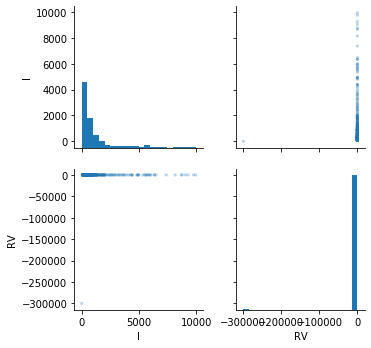

In [9]:
sns.pairplot(dt, 
             vars=["I","RV"], 
             diag_kind='hist',  
             plot_kws=dict(alpha=0.3, s=10, edgecolor='none'),
             diag_kws=dict(bins=20),
            )


In [10]:
mx=(dt.RV<-100)&(dt.RV>-220)
dt=dt[mx]

In [11]:
dte=[109.96,5,-204,2420]
dte=pd.DataFrame(dte).T
dte.columns=['X','Y','RV','I']

In [12]:
dt=pd.concat([dt,dte], ignore_index=True)

In [13]:
dt.describe()

,X,Y,RV,I
count,311.000000,311.000000,311.000000,311.000000
mean,100.337839,9.508039,-201.732423,1309.493794
std,16.416984,7.008228,9.216092,1873.641832
min,75.096000,0.000000,-219.578992,54.730000
25%,85.824000,2.000000,-209.278023,255.950000
50%,99.234000,8.000000,-201.809249,572.700000
75%,113.985000,15.000000,-195.482490,1320.500000
max,128.736000,22.000000,-177.781268,9957.000000


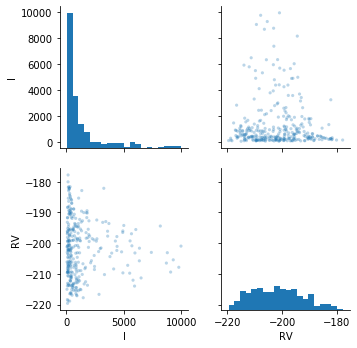

In [14]:
sns.pairplot(dt, 
             vars=["I","RV"], 
             diag_kind='hist',  
             plot_kws=dict(alpha=0.3, s=10, edgecolor='none'),
             diag_kws=dict(bins=20),
            )


Emission Map

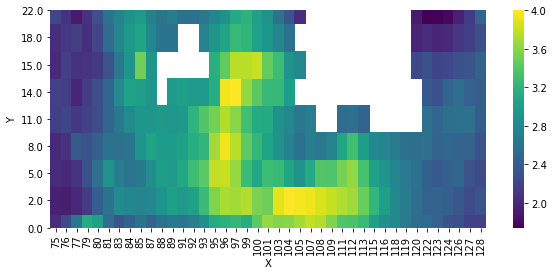

In [15]:
datal=dt.copy()
datal.I=np.log10(datal.I)
datal.X=datal.X.astype(int)
#datal.Y=datal.Y.astype(int)

dataH_f=(datal.round(2)).pivot(index='Y', columns='X', values='I')
fig, ax = plt.subplots(figsize=(sz*ar,sz))
sns.heatmap(dataH_f, cmap="viridis",xticklabels='auto')
plt.gca().invert_yaxis()
plt.xticks(rotation='vertical')
plt.yticks(rotation='horizontal')


plt.rcParams["font.family"]="Times New Roman"
plt.rcParams["font.size"]="16"

Radial Velocity

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


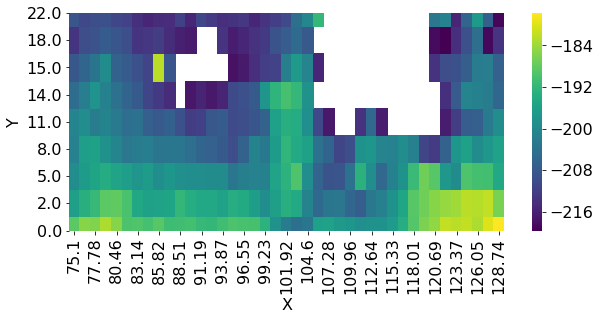

In [16]:
datal=dt.copy()
dataH_rv=(datal.round(2)).pivot(index='Y', columns='X', values='RV')
fig, ax = plt.subplots(figsize=(sz*ar,sz))
sns.heatmap(dataH_rv, cmap="viridis")
plt.gca().invert_yaxis()

Weighted property

In [17]:
W=np.log(abs((dt.RV*dt.I)/dt.I.sum()))
W.head()

0   -1.862384
1   -2.676597
2   -3.139132
3   -3.462646
4   -3.505556
dtype: float64

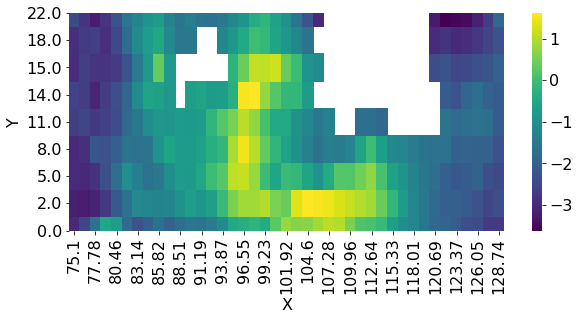

In [18]:
dtW=[dt.X,dt.Y,W]
dtW=pd.DataFrame(dtW).T
dtW.columns=['X','Y','W']

dtH_W=(dtW.round(2)).pivot(index='Y', columns='X', values='W')
fig, ax = plt.subplots(figsize=(sz*ar,sz))
sns.heatmap(dtH_W, cmap="viridis")
plt.gca().invert_yaxis()


Horizontal Polynomial Correction

 
-201.7
 
0.06453 x - 208.2
          2
0.005984 x - 1.158 x - 147.4
            3           2
-0.0002716 x + 0.08879 x - 9.443 x + 124.5
            4             3          2
-5.851e-07 x - 3.369e-05 x + 0.0529 x - 7.062 x + 65.96
           5             4          3         2
1.023e-06 x - 0.0005216 x + 0.1052 x - 10.48 x + 515.8 x - 1.022e+04
            6             5           4         3         2
-9.474e-08 x + 5.891e-05 x - 0.01516 x + 2.066 x - 157.2 x + 6330 x - 1.056e+05


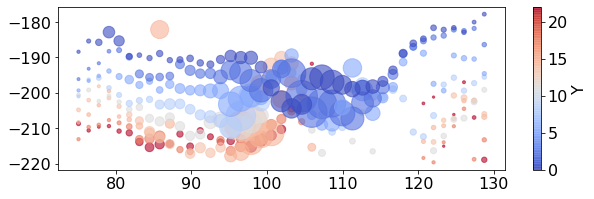

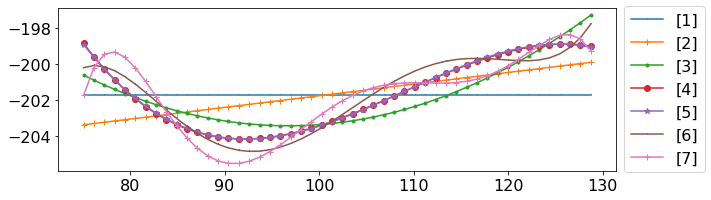

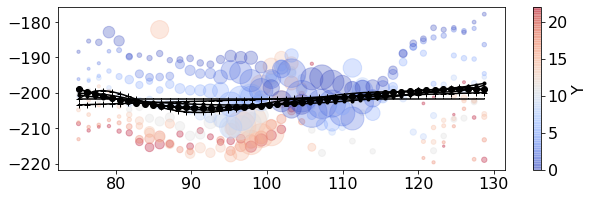

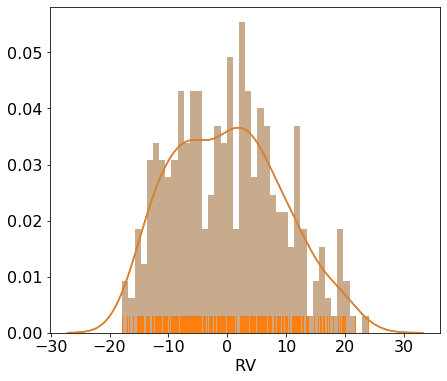

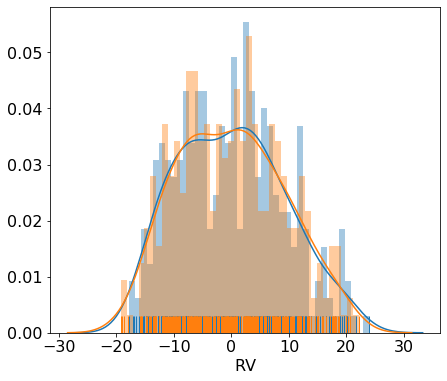

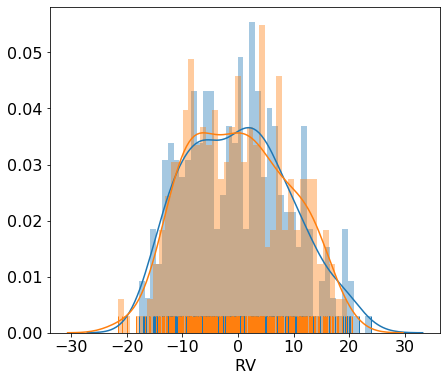

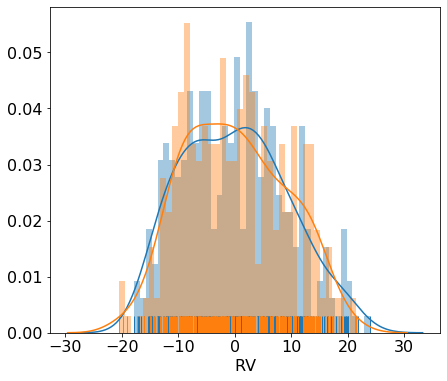

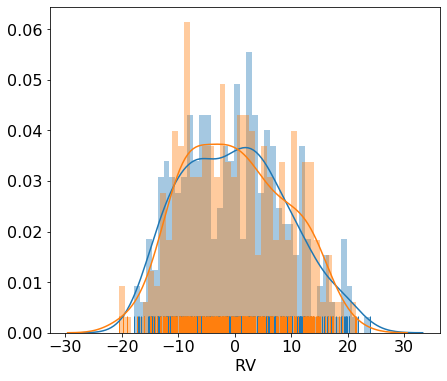

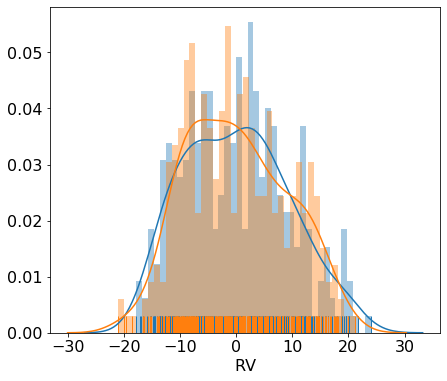

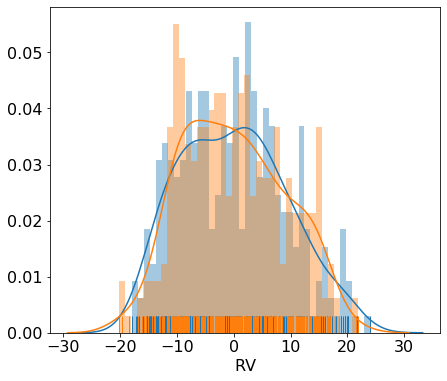

In [19]:
argo1=CPH(dt,n)

Vertical Polynomial Correction

 
-201.7
 
-0.9524 x - 192.7
         2
0.03609 x - 1.705 x - 190.5
           3            2
0.0009083 x + 0.006343 x - 1.463 x - 190.8
        4            3          2
0.0002 x - 0.007778 x + 0.1226 x - 1.95 x - 190.6
           5            4           3          2
8.922e-05 x - 0.004564 x + 0.08038 x - 0.5354 x - 0.2886 x - 191
           6            5           4          3         2
2.509e-05 x - 0.001499 x + 0.03281 x - 0.3205 x + 1.367 x - 3.372 x - 190.7


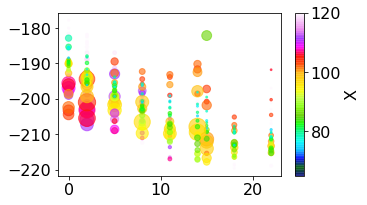

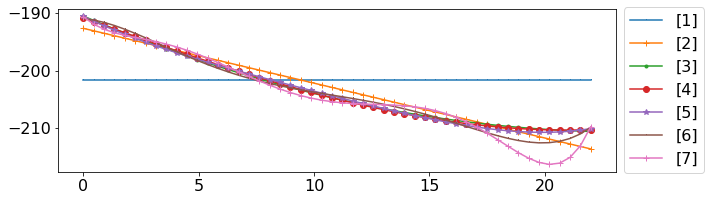

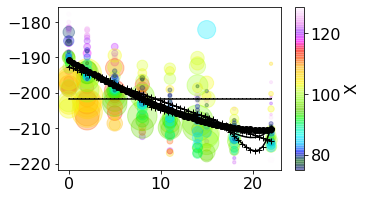

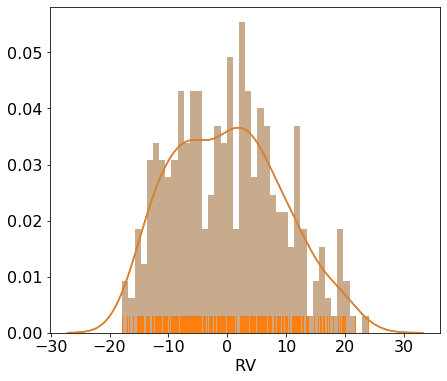

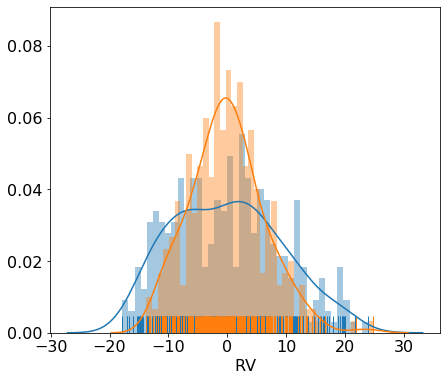

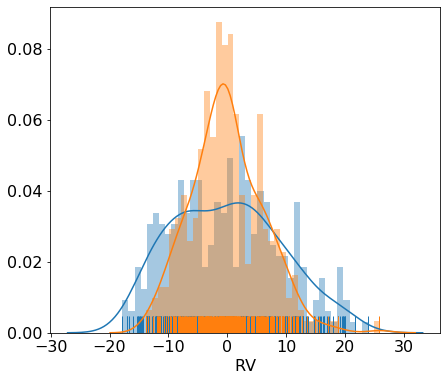

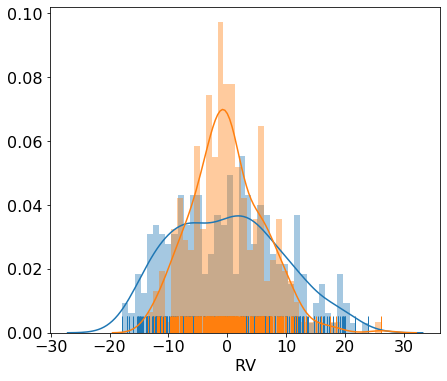

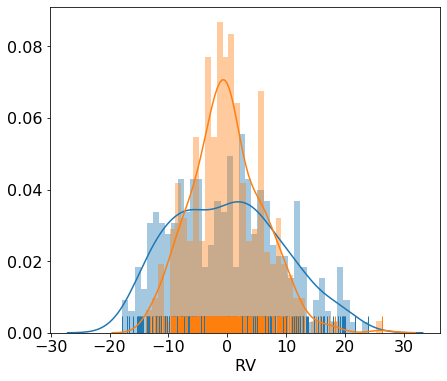

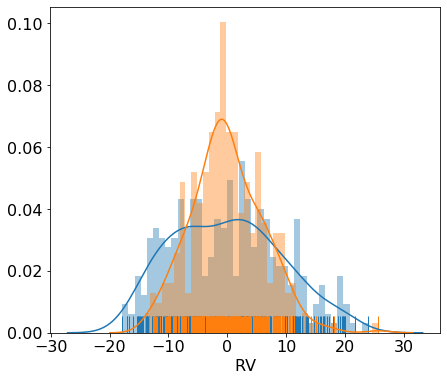

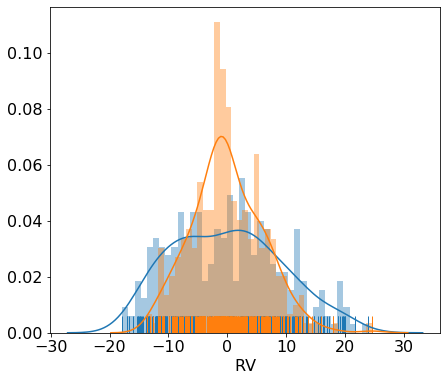

In [20]:
argo2=CPV(dt,n)

Structure Function

In [21]:
SF1=dict()

for i in range(n):
    SF1[i]=sosf(argo1[i])
    
SF2=dict()

for i in range(n):
    SF2[i]=sosf(argo2[i])

/home/zalenovo/Dropbox/Cloud/codepycloud/PhD.Final/SABRE/SABReXX.py:246: RuntimeWarning: divide by zero encountered in double_scalars
  g=e/f
/home/zalenovo/Dropbox/Cloud/codepycloud/PhD.Final/SABRE/SABReXX.py:255: RuntimeWarning: divide by zero encountered in double_scalars
  g=e/f
/home/zalenovo/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/home/zalenovo/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:183: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)


In [22]:
xi=1
xf=15

SF1Data=dict()
SF1Pr=dict()

for i in range(n):
    SF1Data[i],SF1Pr[i]=LR(SF1[i]['Lag'],SF1[i]['Nmqvd'],SF1[i]['ErrY'],xi,xf,n)
    
SF2Data=dict()
SF2Pr=dict()


for i in range(n):
    SF2Data,SF2Pr[i]=LR(SF2[i]['Lag'],SF2[i]['Nmqvd'],SF2[i]['ErrY'],xi,xf,n)

In [23]:
SF1Data,SF2Data

({0:               R        eps     alpha  lags
  Value  0.991386  16.353630  0.883175   2.0
  Err    0.000856   0.708787  0.014137  15.0,
  1:               R        eps     alpha  lags
  Value  0.991368  16.227988  0.885958   2.0
  Err    0.000893   0.704877  0.014200  15.0,
  2:               R        eps     alpha  lags
  Value  0.990932  16.426202  0.867922   2.0
  Err    0.000978   0.720816  0.014329  15.0,
  3:               R        eps     alpha  lags
  Value  0.991207  16.617249  0.863407   2.0
  Err    0.000918   0.724419  0.014176  15.0,
  4:               R        eps     alpha  lags
  Value  0.991223  16.612363  0.863618   2.0
  Err    0.000916   0.724319  0.014179  15.0,
  5:               R        eps     alpha  lags
  Value  0.990677  16.485324  0.865842   2.0
  Err    0.001010   0.724532  0.014335  15.0,
  6:               R        eps     alpha  lags
  Value  0.990318  16.040924  0.866856   2.0
  Err    0.001149   0.721782  0.014709  15.0},
               R        ep

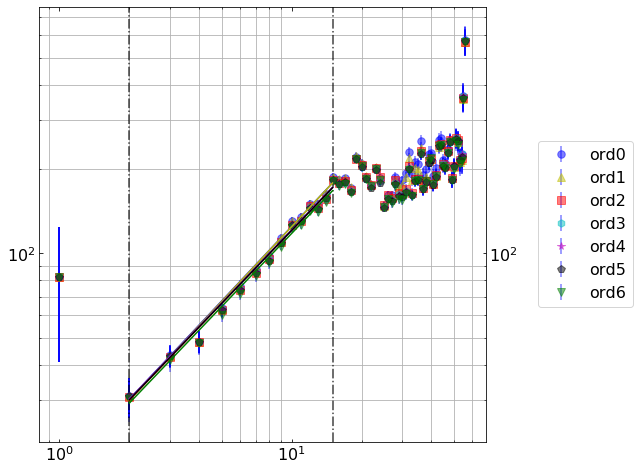

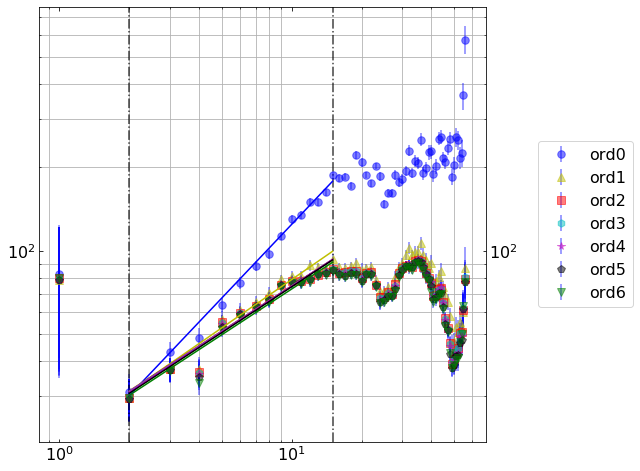

In [24]:
pltdata(SF1,SF1Pr,xi,xf,n)
pltdata(SF2,SF2Pr,xi,xf,n)

Structure Function Norm

In [25]:
SFn1=dict()

for i in range(n):
    SFn1[i]=sosfnorm(argo1[i])
    
SFn2=dict()

for i in range(n):
    SFn2[i]=sosfnorm(argo2[i])

/home/zalenovo/Dropbox/Cloud/codepycloud/PhD.Final/SABRE/SABReXX.py:695: RuntimeWarning: divide by zero encountered in double_scalars
  g=e/f
/home/zalenovo/Dropbox/Cloud/codepycloud/PhD.Final/SABRE/SABReXX.py:704: RuntimeWarning: divide by zero encountered in double_scalars
  g=e/f
/home/zalenovo/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/home/zalenovo/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:183: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)


In [26]:
xi=1
xf=15

SFN1Data=dict()
SFN1Pr=dict()

for i in range(n):
    SFN1Data[i],SFN1Pr[i]=LR(SFn1[i]['Lag'],SFn1[i]['Nmqvd'],SFn1[i]['ErrY'],xi,xf,n)
    
SFN2Data=dict()
SFN2Pr=dict()

for i in range(n):
    SFN2Data[i],SFN2Pr[i]=LR(SFn2[i]['Lag'],SFn2[i]['Nmqvd'],SFn2[i]['ErrY'],xi,xf,n)

In [27]:
SFN1Data,SFN2Data

({0:               R       eps     alpha  lags
  Value  0.991387  0.193073  0.883395   2.0
  Err    0.000865  0.008353  0.014111  15.0,
  1:               R       eps     alpha  lags
  Value  0.991385  0.194194  0.886087   2.0
  Err    0.000882  0.008411  0.014144  15.0,
  2:               R       eps     alpha  lags
  Value  0.990902  0.201422  0.867983   2.0
  Err    0.000969  0.008872  0.014389  15.0,
  3:               R       eps     alpha  lags
  Value  0.991169  0.205578  0.863297   2.0
  Err    0.000908  0.008911  0.014074  15.0,
  4:               R       eps     alpha  lags
  Value  0.991140  0.205554  0.863424   2.0
  Err    0.000908  0.008910  0.014075  15.0,
  5:               R       eps     alpha  lags
  Value  0.990682  0.205011  0.865509   2.0
  Err    0.001023  0.009025  0.014367  15.0,
  6:               R       eps     alpha  lags
  Value  0.990382  0.200804  0.866897   2.0
  Err    0.001126  0.009020  0.014679  15.0},
 {0:               R       eps     alpha  lags


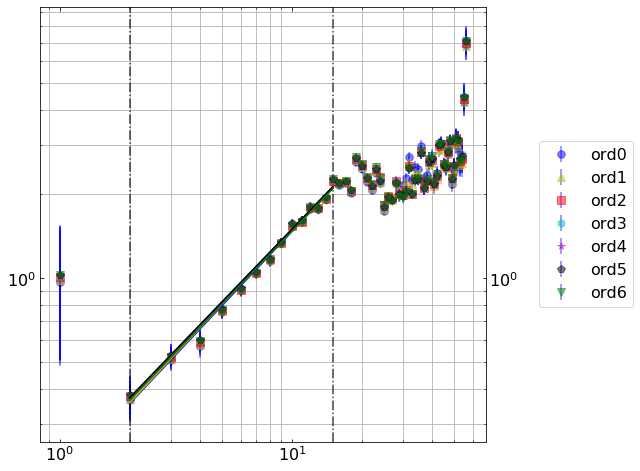

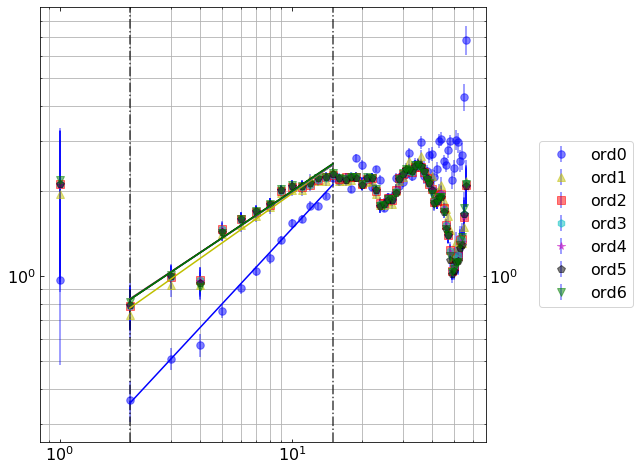

In [28]:
pltdata(SFn1,SFN1Pr,xi,xf,n)
pltdata(SFn2,SFN2Pr,xi,xf,n)

Weighted Structure Function

In [29]:
SFw1=dict()

for i in range(n):
    SFw1[i]=sosfw(argo1[i])

SFw2=dict()

for i in range(n):
    SFw2[i]=sosfw(argo2[i])

/home/zalenovo/Dropbox/Cloud/codepycloud/PhD.Final/SABRE/SABReXX.py:1171: RuntimeWarning: divide by zero encountered in double_scalars
  g=e/f
/home/zalenovo/Dropbox/Cloud/codepycloud/PhD.Final/SABRE/SABReXX.py:1180: RuntimeWarning: divide by zero encountered in double_scalars
  g=e/f
/home/zalenovo/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/home/zalenovo/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:183: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)


In [30]:
xi=1
xf=15

SFW1Data=dict()
SFW1Pr=dict()


for i in range(n):
    SFW1Data[i],SFW1Pr[i]=LR(SFw1[i]['Lag'],SFw1[i]['Nmqvd'],SFw1[i]['ErrY'],xi,xf,n)
    
SFW2Data=dict()
SFW2Pr=dict()


for i in range(n):
    SFW2Data[i],SFW2Pr[i]=LR(SFw2[i]['Lag'],SFw2[i]['Nmqvd'],SFw2[i]['ErrY'],xi,xf,n)

In [31]:
SFW1Data,SFW2Data

({0:               R       eps     alpha  lags
  Value  0.478483  4.541669  0.237206   2.0
  Err    0.033238  0.230988  0.011571  15.0,
  1:               R       eps     alpha  lags
  Value  0.481912  4.544561  0.242289   2.0
  Err    0.032725  0.230824  0.011496  15.0,
  2:               R       eps     alpha  lags
  Value  0.472922  4.746554  0.231187   2.0
  Err    0.034153  0.243947  0.011837  15.0,
  3:              R       eps     alpha  lags
  Value  0.47630  4.708418  0.240411   2.0
  Err    0.03313  0.243137  0.011976  15.0,
  4:               R       eps    alpha  lags
  Value  0.476643  4.710507  0.24036   2.0
  Err    0.033132  0.243480  0.01200  15.0,
  5:               R       eps     alpha  lags
  Value  0.481361  4.665120  0.250230   2.0
  Err    0.032426  0.243964  0.012409  15.0,
  6:               R       eps     alpha  lags
  Value  0.453192  4.640612  0.243388   2.0
  Err    0.032238  0.236227  0.011669  15.0},
 {0:               R       eps     alpha  lags
  Valu

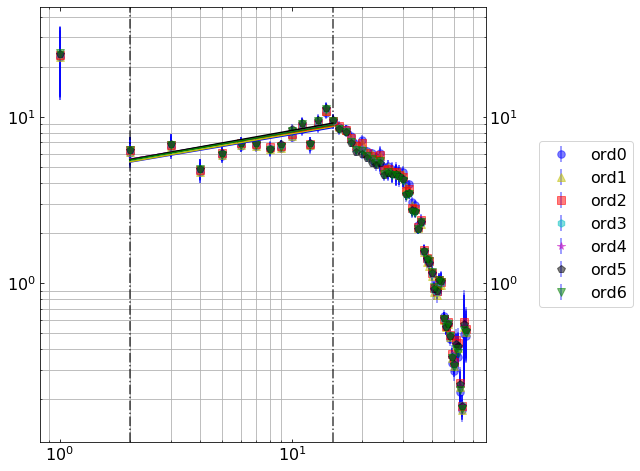

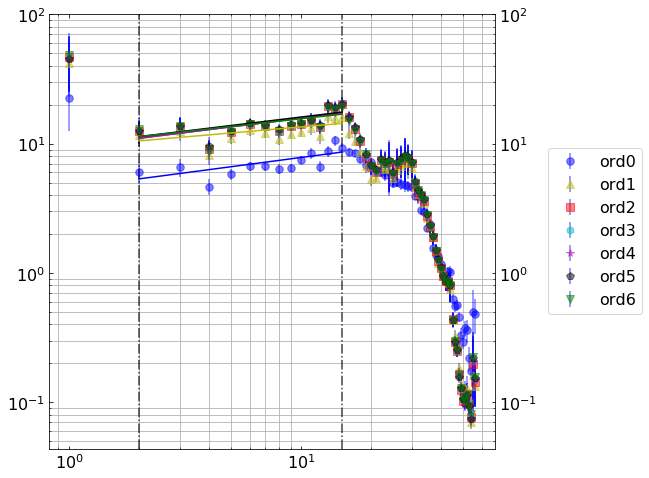

In [32]:
pltdata(SFw1,SFW1Pr,xi,xf,n)
pltdata(SFw2,SFW2Pr,xi,xf,n)

Weighted Property

In [33]:
SFwII1=dict()

for i in range(n):
    SFwII1[i]=sosfw2(argo1[i])
    
SFwII2=dict()

for i in range(n):
    SFwII2[i]=sosfw2(argo1[i])

/home/zalenovo/Dropbox/Cloud/codepycloud/PhD.Final/SABRE/SABReXX.py:1651: RuntimeWarning: divide by zero encountered in double_scalars
  g=e/f
/home/zalenovo/Dropbox/Cloud/codepycloud/PhD.Final/SABRE/SABReXX.py:1660: RuntimeWarning: divide by zero encountered in double_scalars
  g=e/f
/home/zalenovo/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:151: RuntimeWarning: invalid value encountered in reduce
  ret = umr_sum(arr, axis, dtype, out, keepdims)
/home/zalenovo/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:183: RuntimeWarning: invalid value encountered in reduce
  arrmean = umr_sum(arr, axis, dtype, keepdims=True)


In [34]:
xi=1
xf=25

SFWII1Data=dict()
SFWII1Pr=dict()

for i in range(n):
    SFWII1Data[i],SFWII1Pr[i]=LR(SFwII1[i]['Lag'],SFwII1[i]['Nmqvd'],SFwII1[i]['ErrY'],xi,xf,n)
    
SFWII2Data=dict()
SFWII2Pr=dict()

for i in range(n):
    SFWII2Data[i],SFWII2Pr[i]=LR(SFwII2[i]['Lag'],SFwII2[i]['Nmqvd'],SFwII2[i]['ErrY'],xi,xf,n)

In [35]:
SFWII1Data,SFWII2Data

({0:               R       eps     alpha    lags
  Value  0.757861  1.265183  0.246407   2.000
  Err    0.010485  0.056541  0.009987  24.894,
  1:               R       eps     alpha    lags
  Value  0.729344  1.312244  0.232631   2.000
  Err    0.012485  0.058770  0.010055  24.894,
  2:               R       eps     alpha    lags
  Value  0.804820  1.221916  0.257995   2.000
  Err    0.011452  0.056033  0.010661  24.894,
  3:               R       eps     alpha    lags
  Value  0.754615  1.295765  0.235193   2.000
  Err    0.015407  0.059999  0.010871  24.894,
  4:               R       eps     alpha    lags
  Value  0.755834  1.293936  0.235709   2.000
  Err    0.015326  0.059936  0.010881  24.894,
  5:               R       eps     alpha    lags
  Value  0.732547  1.315265  0.228521   2.000
  Err    0.017506  0.061066  0.011033  24.894,
  6:               R       eps     alpha    lags
  Value  0.727217  1.340559  0.222799   2.000
  Err    0.018795  0.062503  0.010972  24.894},
 {0: 

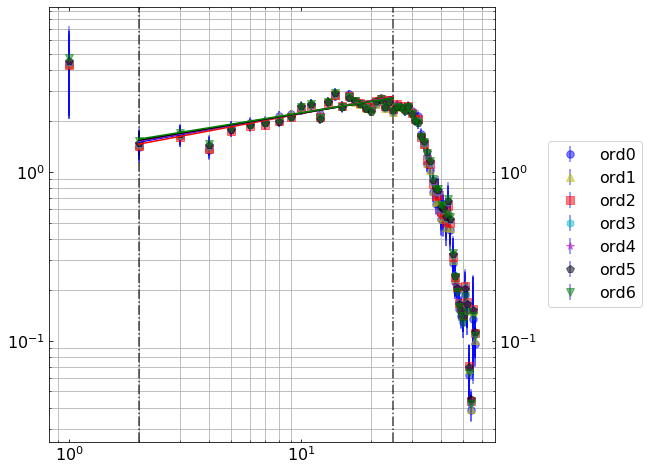

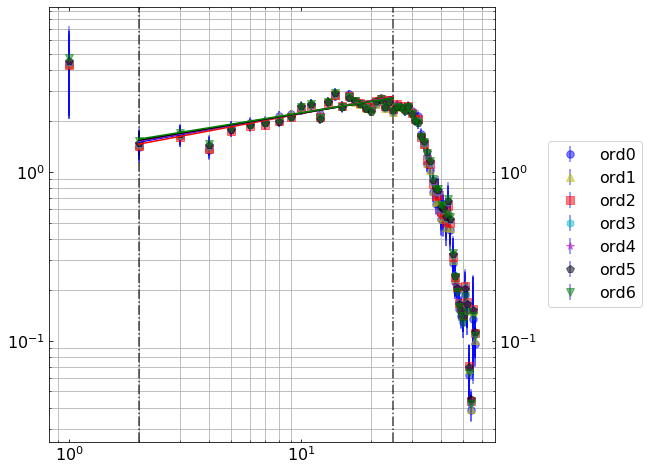

In [36]:
pltdata(SFwII1,SFWII1Pr,xi,xf,n)
pltdata(SFwII2,SFWII2Pr,xi,xf,n)

Structure Function Dr. Will

In [37]:
SFwh1=dict()

for i in range(n):
    SFwh1[i]=sfwh(argo1[i])
    
SFwh2=dict()

for i in range(n):
    SFwh2[i]=sfwh(argo2[i])

/home/zalenovo/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/home/zalenovo/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:198: RuntimeWarning: Mean of empty slice.
  line, = ax.plot(a.mean(), 0)
/home/zalenovo/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/zalenovo/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:898: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


In [38]:
xi=1
xf=25

SFwh1Data=dict()
SFwh1Pr=dict()

for i in range(n):
    SFwh1Data[i],SFwh1Pr[i]=LR(SFwh1[i]['Lag'],SFwh1[i]['Nmqvd'],SFwh1[i]['ErrY'],xi,xf,n)
    
SFwh2Data=dict()
SFwh2Pr=dict()

for i in range(n):
    SFwh2Data[i],SFwh2Pr[i]=LR(SFwh2[i]['Lag'],SFwh2[i]['Nmqvd'],SFwh2[i]['ErrY'],xi,xf,n)

In [39]:
SFwh1Data,SFwh2Data

({0:               R        eps     alpha    lags
  Value  0.873827  21.066212  0.782982   5.096
  Err    0.000752   0.400502  0.002114  23.950,
  1:               R        eps     alpha    lags
  Value  0.903913  19.233465  0.838980   5.096
  Err    0.000571   0.371765  0.002351  23.950,
  2:               R        eps     alpha    lags
  Value  0.900528  18.806688  0.827345   5.096
  Err    0.000353   0.399986  0.002862  23.950,
  3:               R        eps     alpha    lags
  Value  0.909357  17.668760  0.836333   5.096
  Err    0.000137   0.409076  0.003492  23.950,
  4:               R        eps     alpha    lags
  Value  0.909538  17.660010  0.836342   5.096
  Err    0.000136   0.408985  0.003495  23.950,
  5:               R        eps     alpha    lags
  Value  0.902527  18.308035  0.818821   5.096
  Err    0.000113   0.418218  0.003329  23.950,
  6:               R        eps     alpha    lags
  Value  0.904968  16.993780  0.846042   5.096
  Err    0.000002   0.420606  0.0

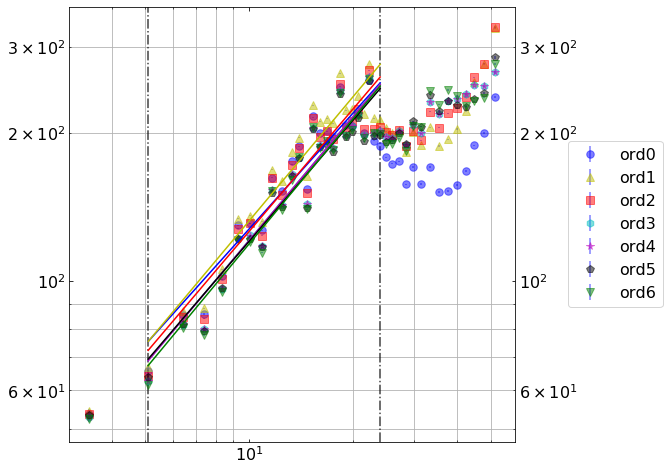

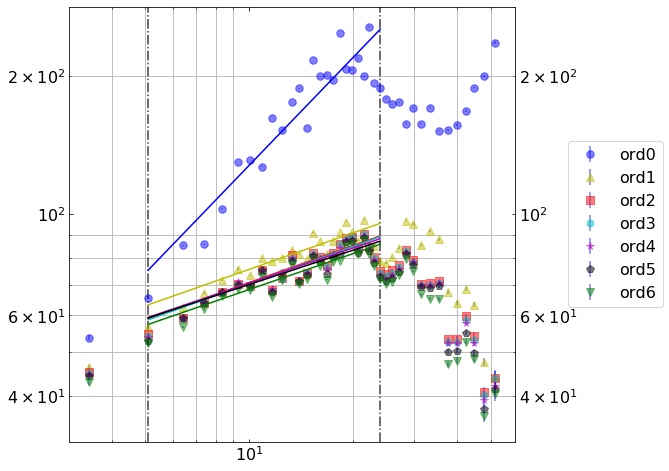

In [40]:
pltdata(SFwh1,SFwh1Pr,xi,xf,n)
pltdata(SFwh2,SFwh2Pr,xi,xf,n)

Autocorrelation Function

In [41]:
AF1=dict()

for i in range(n):
    AF1[i]=acf(argo1[i])
    
AF2=dict()

for i in range(n):
    AF2[i]=acf(argo2[i])

In [42]:
AF1Data=dict()
AF1Inter=dict()


for i in range(n):

    AF1Data[i],AF1Inter[i]=ACLR(AF1[i])
    
AF2Data=dict()
AF2Inter=dict()


for i in range(n):

    AF2Data[i],AF2Inter[i]=ACLR(AF2[i])
    

AF1Data,AF2Data 

({0: array([12.41509632]),
  1: array([12.21656121]),
  2: array([12.09430672]),
  3: array([12.00177786]),
  4: array([12.00324786]),
  5: array([11.9671402]),
  6: array([12.03144211])},
 {0: array([12.41509632]),
  1: array([10.4694052 , 22.43360374, 29.38834664, 45.91212831]),
  2: array([10.19101527, 22.49062574, 29.44980075, 45.30739744, 55.66962638]),
  3: array([10.16949111, 22.48775611, 29.45493156, 45.24120148, 55.74292768,
         56.26551635]),
  4: array([10.15234466, 22.50832555, 29.46098565, 45.20253361, 55.80256761,
         56.2171664 ]),
  5: array([10.23443891, 22.56132889, 29.46418069, 45.14143899]),
  6: array([10.24499884, 22.6008516 , 29.49057839, 45.14422224, 55.51593745])})

findfont: Font family ['Times New Roman'] not found. Falling back to DejaVu Sans.


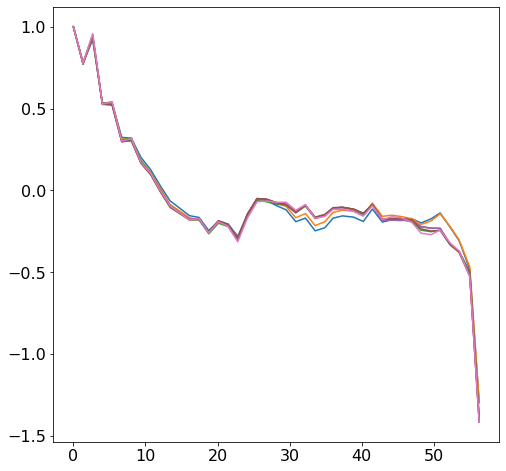

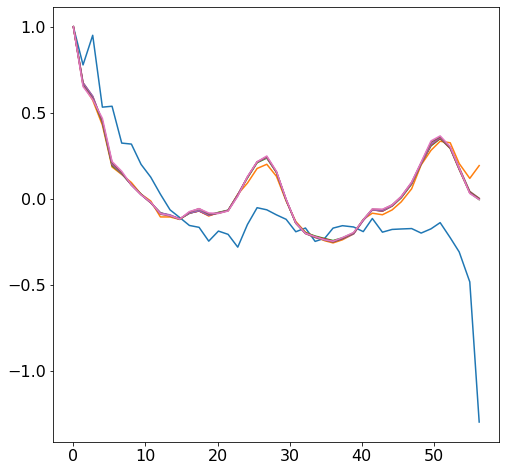

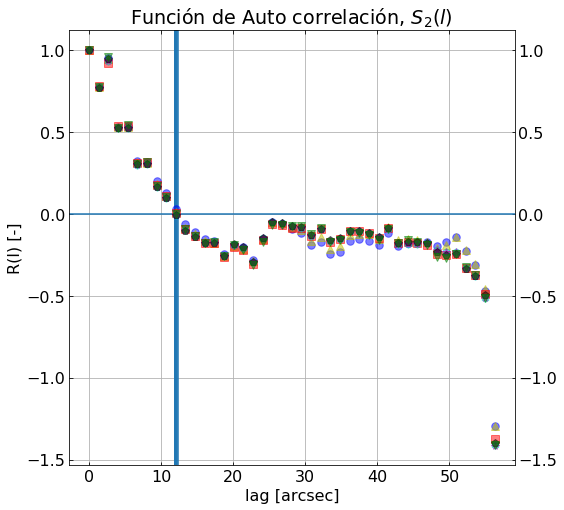

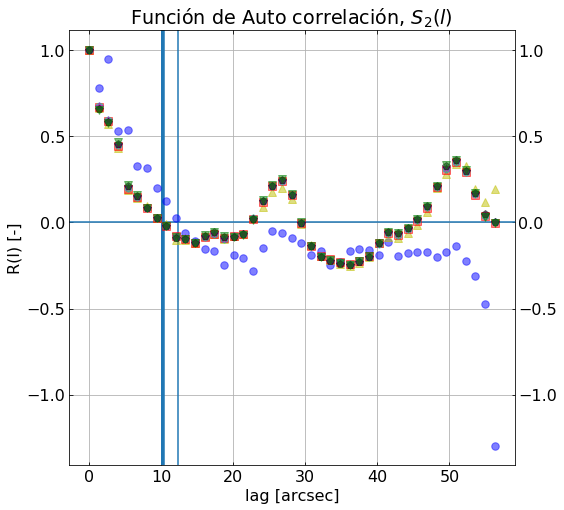

In [43]:
fig, ax=plt.subplots(figsize=(8,8))

for i in range(n):
    plt.plot(AF1[i]['Lag'],AF1[i]['Nmqvd'])

fig, ax=plt.subplots(figsize=(8,8))
    
for i in range(n):
    plt.plot(AF2[i]['Lag'],AF2[i]['Nmqvd'])
    
marker=itertools.cycle(('o','^','s','h','*','p','v'))
color=itertools.cycle(('b','y','r','c','m','k','g'))

fig, ax=plt.subplots(figsize=(8,8))

for i in range(n):
    ax.errorbar(AF1Inter[i][0],AF1Inter[i][1],fmt=next(marker),color=next(color), ecolor='b', alpha=0.5, markersize=7.5, label='ord' + str(i))

ax.set(xlabel='lag [arcsec]', ylabel='R(l) [-]')
plt.title('Función de Auto correlación, $S_{2}(l)$')
plt.tick_params(which='both', labelright=True, direction='in', right=True,  top=True)
plt.grid()
plt.axhline(y=0)

for y in range(n):
    for i in range(1):
        plt.axvline(x=AF1Data[y][i])



marker=itertools.cycle(('o','^','s','h','*','p','v'))
color=itertools.cycle(('b','y','r','c','m','k','g'))

fig, ax=plt.subplots(figsize=(8,8))

for i in range(n):
    ax.errorbar(AF2Inter[i][0],AF2Inter[i][1],fmt=next(marker),color=next(color), ecolor='b', alpha=0.5, markersize=7.5, label='ord' + str(i))

ax.set(xlabel='lag [arcsec]', ylabel='R(l) [-]')
plt.title('Función de Auto correlación, $S_{2}(l)$')
plt.tick_params(which='both', labelright=True, direction='in', right=True,  top=True)
plt.grid()
plt.axhline(y=0)

for y in range(n):
    for i in range(1):
        plt.axvline(x=AF2Data[y][i])

1DPSD

In [44]:
#PS1=dict()

#for i in range(n):
#    PS1[i]=ps(argo1[i])
    
#PS2=dict()

#for i in range(n):
#    PS2[i]=ps(argo2[i])

In [45]:
#xi=1
#xf=20

#PS1Data=dict()
#mx=len(PS1[i]['k'])
#PS1Pr=dict()

#for i in range(n):
#    PS1Data[i],PS1Pr[i]=LR(PS1[i]['k'][1:mx],PS1[i]['Pk'][1:mx],PS1[i]['Err'][1:mx],xi,xf,n)
    
#PS2Data=dict()
#PS2Pr=dict()

#for i in range(n):
#    PS2Data[i],PS2Pr[i]=LR(PS2[i]['k'][1:mx],PS2[i]['Pk'][1:mx],PS2[i]['Err'][1:mx],xi,xf,n)

In [46]:
#PS1Data,PS2Data

In [47]:
#pltdata(PS1,PS1Pr,xi+1,xf,n)
#pltdata(PS2,PS2Pr,xi+1,xf,n)

In [48]:
#PS1k=dict()

#for i in range(n):
#    PS1k[i]=psk(argo1[i])
    
#PS2k=dict()

#for i in range(n):
#    PS2k[i]=psk(argo2[i])

In [49]:
#xi=1
#xf=19

#PS1kData=dict()
#mx=len(PS1k[0]['k'])
#PS1kPr=dict()

#for i in range(n):
#    PS1kData[i],PS1kPr[i]=LR(PS1k[i]['k'][1:mx],PS1k[i]['Pk'][1:mx],PS1k[i]['Err'][1:mx],xi,xf,n)
    
#PS2kData=dict()
#PS2kPr=dict()

#for i in range(n):
#    PS2kData[i],PS2kPr[i]=LR(PS2k[i]['k'][1:mx],PS2k[i]['Pk'][1:mx],PS2k[i]['Err'][1:mx],xi,xf,n)

In [50]:
#PS1kData,PS2kData

In [51]:
#pltdata(PS1k,PS1kPr,xi,xf+1,n)
#pltdata(PS2k,PS1kPr,xi,xf+1,n)

1DPSD Turbustat

In [52]:
PST1a=dict()
PST1b=dict()


for i in range(n):
    PST1a[i],PST1b[i]=pst(argo1[i])
    
PST2a=dict()
PST2b=dict()

for i in range(n):
    PST2a[i],PST1b[i]=pst(argo2[i])

/home/zalenovo/anaconda3/lib/python3.7/site-packages/turbustat/statistics/base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
/home/zalenovo/anaconda3/lib/python3.7/site-packages/turbustat/statistics/elliptical_powerlaw.py:237: RuntimeWarning: overflow encountered in exp
  ellip = 1. / (1 + np.exp(-ellip_transf))
/home/zalenovo/anaconda3/lib/python3.7/site-packages/turbustat/statistics/base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
/home/zalenovo/anaconda3/lib/python3.7/site-packages/turbustat/statistics/base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
/home/zalenovo/anaconda3/lib/python3.7/site-packages/turbustat/statistics/base_statistic.py:66: UserWarning: Header missing beam information.
  warn("Header missing beam information.")
/home/zalenovo/anaconda3/lib/python3.7/site-packages/turbustat/statisti

In [53]:
for i in range(n):
    print(PST1a[i].slope2D,PST1a[i].slope2D_err)
    


-1.167817564404748 0.08314177408341061
-1.1824660225555021 0.1898282560269694
-1.167126179422502 0.15213185357609138
-1.1724387056375547 0.2298349193757051
-1.1710118019730062 0.1456729052824809
-1.1806053892047428 0.17721508089126292
-1.1783842009031198 0.19805762332475174


In [54]:
for i in range(n):
    print(PST2a[i].slope2D,PST2a[i].slope2D_err)

-1.167817564404748 0.07073638778294133
-1.7826170370715915 0.22364358259243466
-1.698367624118593 0.20720260557452175
-1.7242364763485911 0.20148149392071724
-1.6876435249588337 0.21780949614669287
-1.5963501360346675 0.16997320572078878
-1.3558830783522053 0.28931855425759634


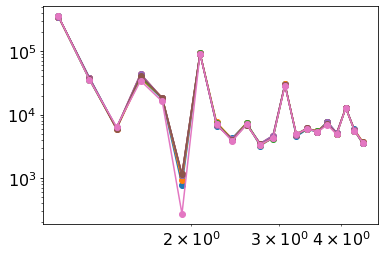

In [55]:
for i in range(n):
    plt.loglog(PST1a[i].wavenumbers,PST1a[i].ps1D,'o-', label=str(i))
    #plt.legend()

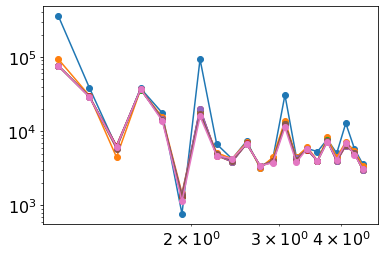

In [56]:
for i in range(n):
    plt.loglog(PST2a[i].wavenumbers,PST2a[i].ps1D,'o-', label=str(i))
    #plt.legend()

In [57]:
print("--- %s seconds ---" % (time.time()-start_time))

--- 150.11909103393555 seconds ---


In [58]:
#SF1

In [59]:
#SF1.to_csv('SF1.csv')